# 1_EDA_master.ipynb

Master EDA notebook. Imports shared helpers from `utils.py`. Run top-to-bottom.

Outputs saved to `eda_outputs/`. 

In [2]:
# Imports & config
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import read_csv_fallback, normalize_columns, ensure_month_features, ensure_season_features, detect_target_column, basic_checks

sns.set(style='whitegrid')
ROOT = Path.cwd()
CSV = ROOT / 'merged_final.csv'
OUT = ROOT / 'eda_outputs'
OUT.mkdir(exist_ok=True)

# Load
df = read_csv_fallback(CSV)
df = normalize_columns(df)
print('Loaded', CSV, 'shape:', df.shape)
print('\nBasic checks:')
print(basic_checks(df))


Loaded /Users/parthpatel/Mtech/DA_204o_Project/merged_final.csv shape: (287288, 11)

Basic checks:
{'shape': (287288, 11), 'columns': ['date', 'state_name', 'districtname', 'average_soilmoisture_level_(at_15cm)', 'average_soilmoisture_volume_(at_15cm)', 'aggregate_soilmoisture_percentage_(at_15cm)', 'volume_soilmoisture_percentage_(at_15cm)', 'Year', 'Month', 'Day', 'Season'], 'missing_counts': {'date': 0, 'state_name': 0, 'districtname': 0, 'average_soilmoisture_level_(at_15cm)': 0, 'average_soilmoisture_volume_(at_15cm)': 0, 'aggregate_soilmoisture_percentage_(at_15cm)': 0, 'volume_soilmoisture_percentage_(at_15cm)': 0, 'Year': 0, 'Month': 0, 'Day': 0, 'Season': 0}, 'duplicates': 0}


## Prepare month & season features (non-destructive)

In [3]:
df = ensure_month_features(df)
df = ensure_season_features(df)
print('Month_num sample:', df['Month_num'].dropna().unique()[:10])
print('Season_num sample:', df['Season_num'].dropna().unique()[:10])


Month_num sample: <IntegerArray>
[6, 7, 8, 9, 10, 11, 12, 1, 2, 3]
Length: 10, dtype: Int64
Season_num sample: <IntegerArray>
[3, 4, 1, 2]
Length: 4, dtype: Int64


## Target detection & summary

In [4]:
target = detect_target_column(df)
if target is None:
    raise KeyError('Target (soil moisture) not found')
print('Target column:', target)
print(df[target].describe())


Target column: average_soilmoisture_level_(at_15cm)
count    287288.000000
mean          2.059794
std           2.920857
min           0.000000
25%           0.010000
50%           0.630000
75%           3.150000
max          19.020000
Name: average_soilmoisture_level_(at_15cm), dtype: float64


## Distributions & skewness

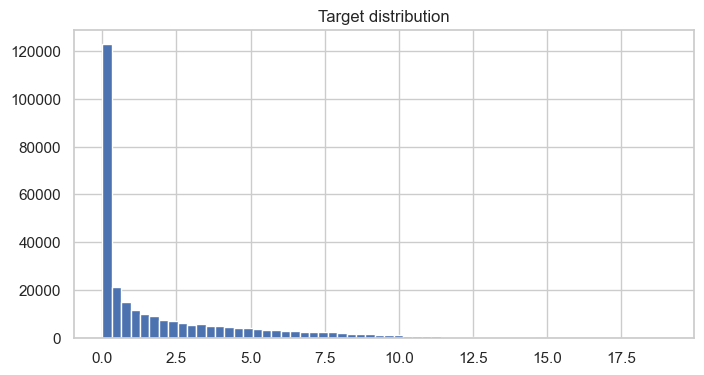

Skewness: 1.8150140644644313


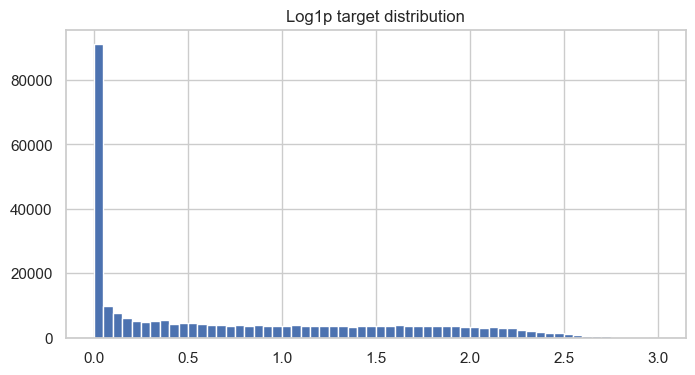

In [5]:
import os
# Distribution
plt.figure(figsize=(8,4))
plt.hist(df[target].dropna(), bins=60)
plt.title('Target distribution')
plt.savefig(OUT/'target_distribution.png', dpi=150)
plt.show()

print('Skewness:', df[target].skew())
# Log1p preview
plt.figure(figsize=(8,4))
plt.hist(np.log1p(df[target].clip(lower=0)).dropna(), bins=60)
plt.title('Log1p target distribution')
plt.savefig(OUT/'target_log1p.png', dpi=150)
plt.show()


## Season-wise, Month-wise, State-wise analysis

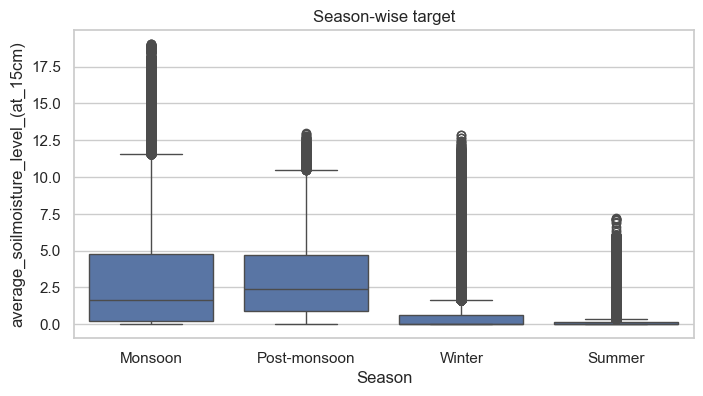

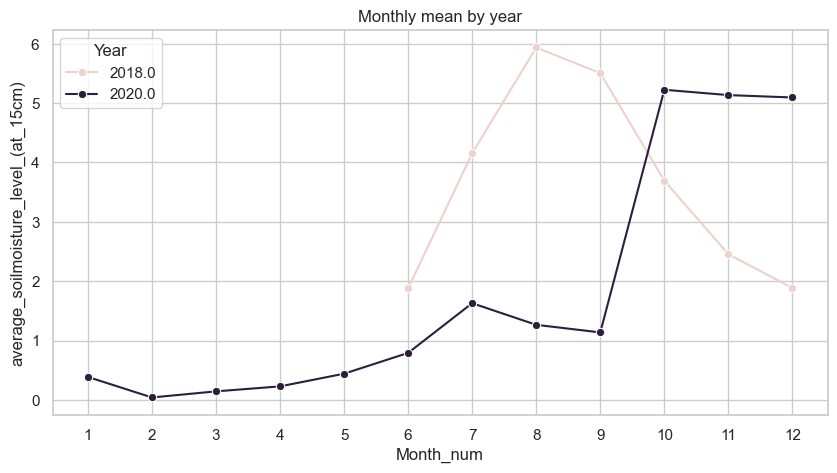

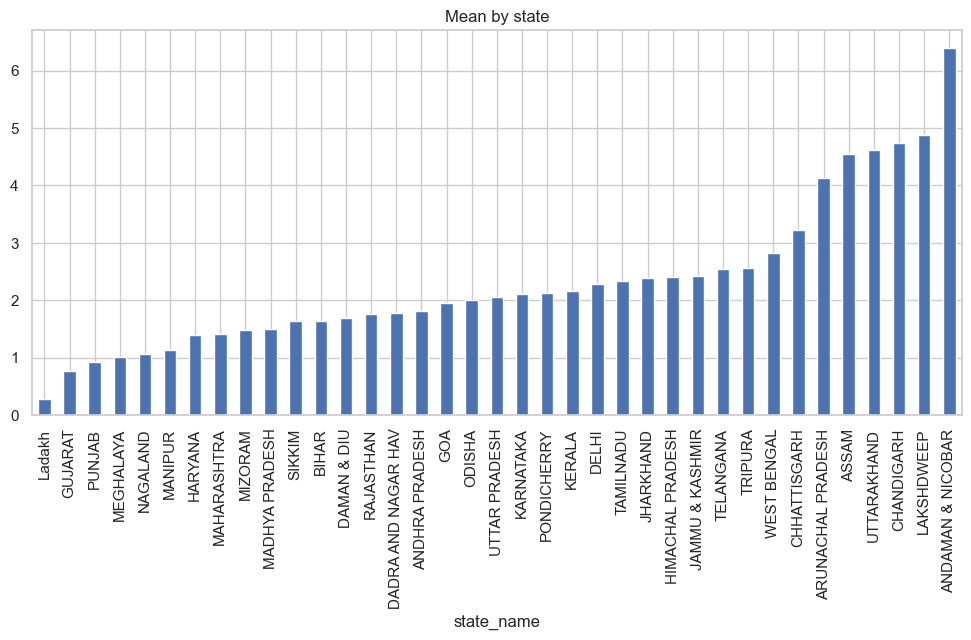

In [6]:
# Season boxplot
plt.figure(figsize=(8,4))
order = ['Monsoon','Post-monsoon','Winter','Summer']
existing = [s for s in order if s in df['Season'].unique()]
import seaborn as sns
sns.boxplot(data=df, x='Season', y=target, order=existing)
plt.title('Season-wise target')
plt.savefig(OUT/'season_boxplot.png', dpi=150)
plt.show()

# Month trend by year
if 'Year' in df.columns:
    month_mean = df.groupby(['Month_num','Year'])[target].mean().reset_index()
    plt.figure(figsize=(10,5))
    sns.lineplot(data=month_mean, x='Month_num', y=target, hue='Year', marker='o')
    plt.xticks(ticks=range(1,13))
    plt.title('Monthly mean by year')
    plt.savefig(OUT/'monthly_by_year.png', dpi=150)
    plt.show()

# State mean
state_mean = df.groupby('state_name')[target].mean().sort_values()
plt.figure(figsize=(12,5))
state_mean.plot(kind='bar')
plt.title('Mean by state')
plt.savefig(OUT/'state_mean.png', dpi=150)
plt.show()


## Correlation & pairplot (sample)

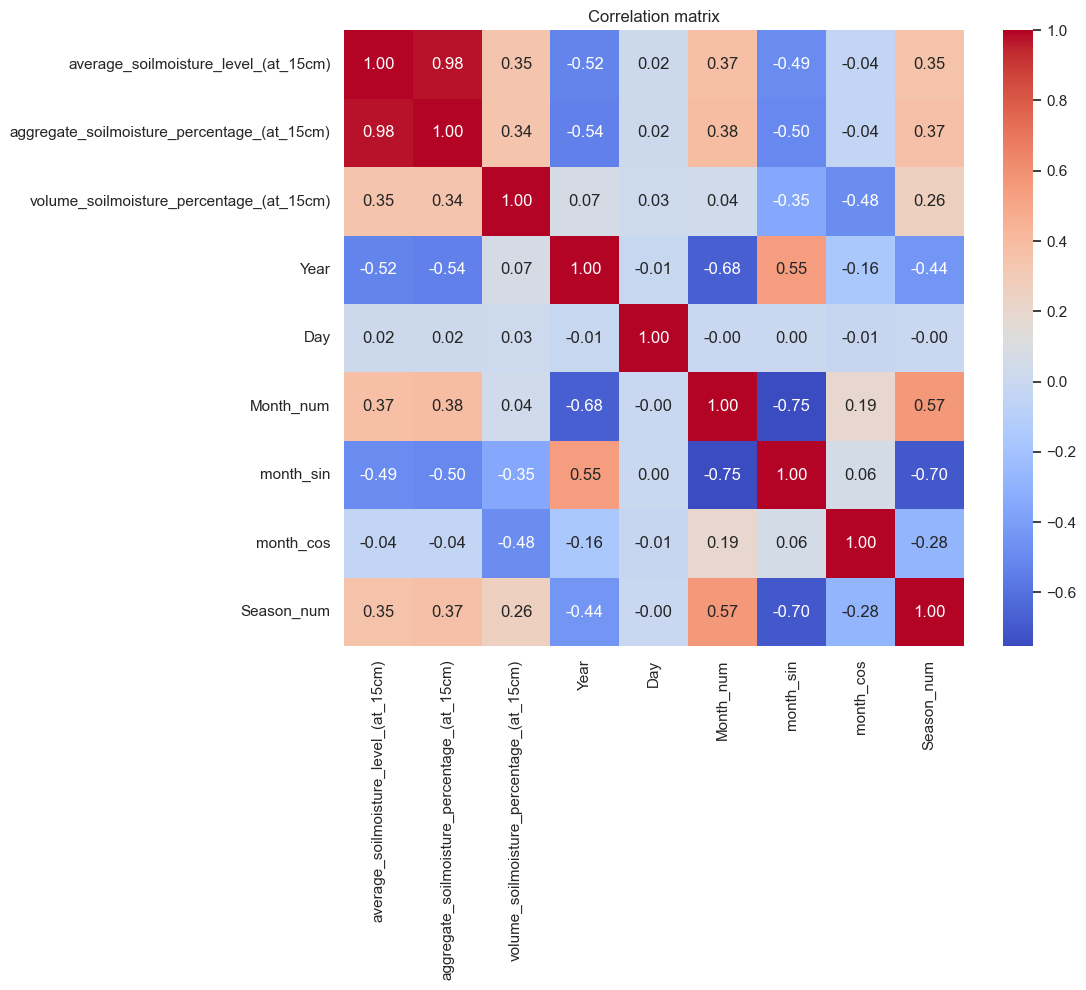

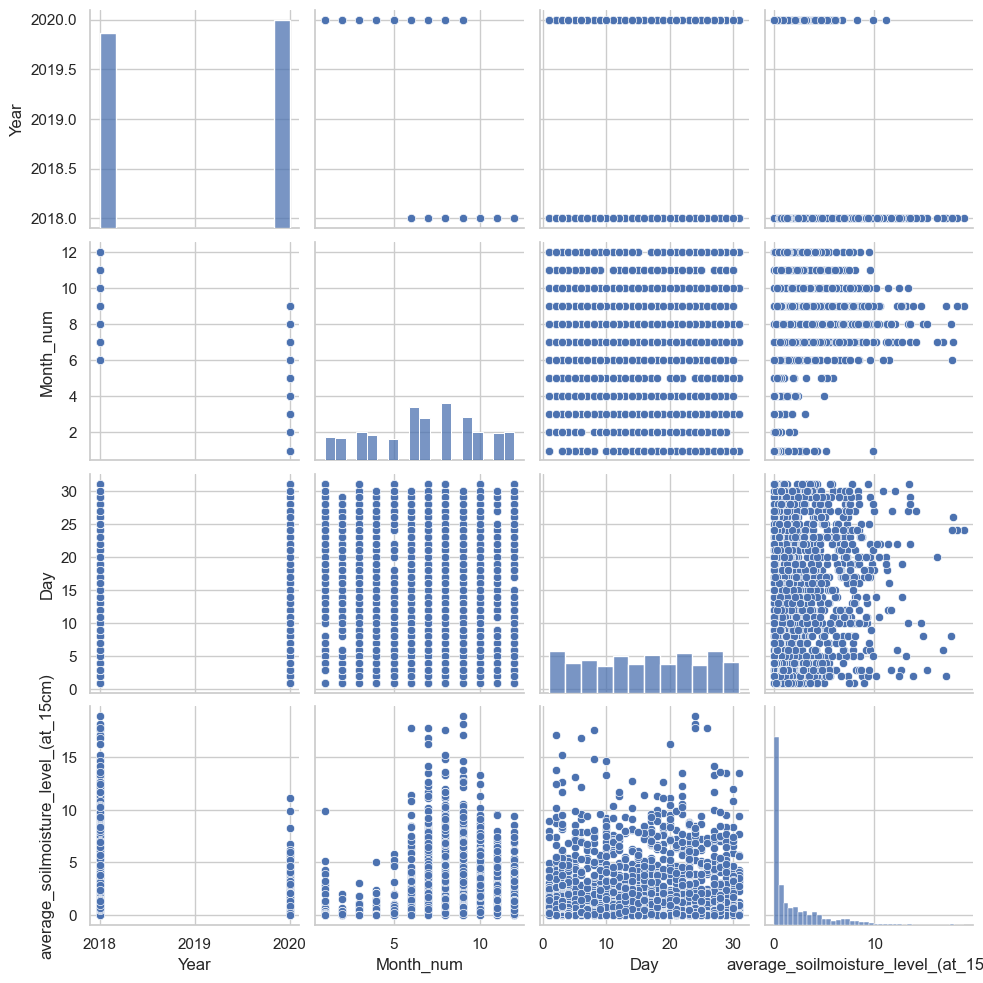

In [7]:
num_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10,8))
sns.heatmap(num_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix')
plt.savefig(OUT/'correlation_matrix.png', dpi=150)
plt.show()

# pairplot sample
cols_for_pair = [c for c in ['Year','Month_num','Day', target] if c in df.columns]
if len(cols_for_pair) >= 2:
    sns.pairplot(df[cols_for_pair].dropna().sample(min(2000, len(df))))
    plt.savefig(OUT/'pairplot_sample.png', dpi=150)
    plt.show()


## Time-series overview (global)

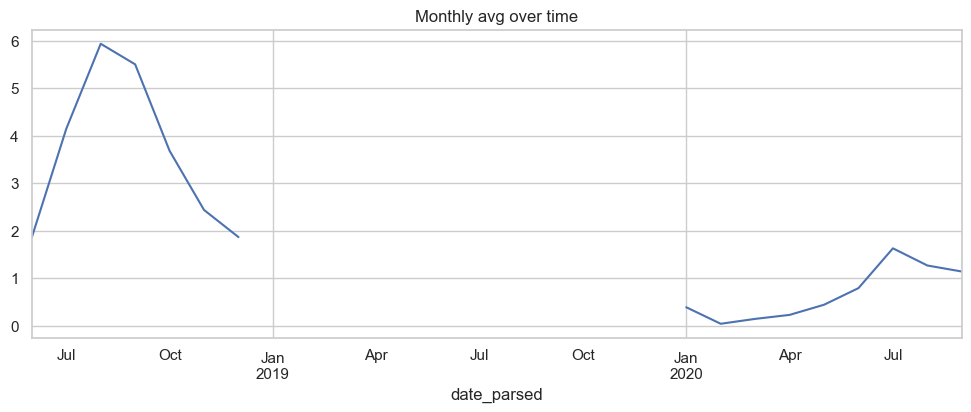

In [8]:
if 'date' in df.columns:
    df['date_parsed'] = pd.to_datetime(df['date'], errors='coerce')
if 'date_parsed' in df.columns and df['date_parsed'].notna().any():
    ts = df.set_index('date_parsed').sort_index()[target].resample('MS').mean()
    plt.figure(figsize=(12,4))
    ts.plot()
    plt.title('Monthly avg over time')
    plt.savefig(OUT/'timeseries_monthly_avg.png', dpi=150)
    plt.show()
else:
    print('No date_parsed available')


## Save small summaries

In [9]:
# save state and month summaries
state_mean.reset_index().to_csv(OUT/'state_mean_summary.csv', index=False)
if 'Month_num' in df.columns:
    df.groupby('Month_num')[target].mean().reset_index().to_csv(OUT/'month_mean_summary.csv', index=False)
print('Saved summaries to', OUT)


Saved summaries to /Users/parthpatel/Mtech/DA_204o_Project/eda_outputs
